# Geocentric models for planetary motion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(5206)
plt.rcParams["savefig.bbox"] = "tight"
fig_save_dir = "../figures/"

## Retrograde motion

We use the [`solarsystem`](https://github.com/IoannisNasios/solarsystem) library to simulate the planet positions.

In [2]:
import solarsystem
from datetime import date, timedelta

In [3]:
def daterange(start_date: date, end_date: date) -> date:
    """A simple iterator through dates
    """
    for n in range((end_date - start_date).days):
        yield start_date + timedelta(n)

Let us generate some data on the orbits of Earth and Mercury in 2024.

In [4]:
start = date(2024, 1, 1)
end = date(2024, 12, 31)

mercury_locations = []
earth_locations = []
dates = []

for d in daterange(start, end):
    H = solarsystem.Heliocentric(
        year=d.year, month=d.month, day=d.day, hour=12, minute=0, view="rectangular"
    )
    dates.append(d)
    mercury_locations.append(H.planets()["Mercury"])
    earth_locations.append(H.planets()["Earth"])

mercury_locations = np.array(mercury_locations)
earth_locations = np.array(earth_locations)

Let us now take a geocentric view, and compute the relative position of Mercury with respect to Earth

In [5]:
relative_locations = mercury_locations - earth_locations

Now we visualise the orbits - observe that the obvious retrograde motion

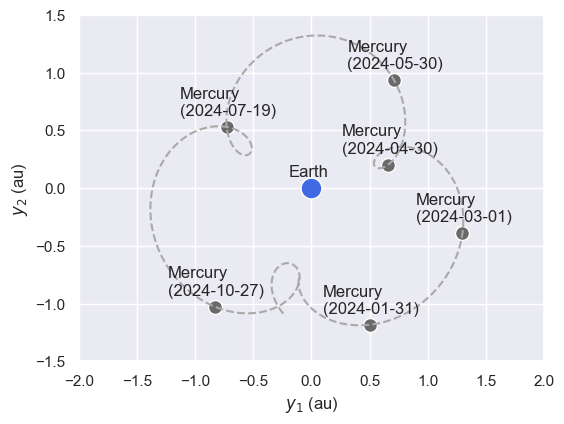

In [6]:
plt.figure(figsize=(6, 4.5))

plt.xlabel("$y_1$ (au)")
plt.ylabel("$y_2$ (au)")

plt.xlim(-2, 2)
plt.ylim(-1.5, 1.5)

# Plot Earth
plt.plot(0, 0, "o", markersize=15, markeredgecolor="white", markerfacecolor="royalblue")
plt.annotate("Earth", (0, 0), (-0.2, 0.1))

# Plot Mercury locations for some dates
for d in [30, 60, 120, 150, 200, 300]:
    x, y = relative_locations[d, :-1]
    plt.plot(
        x, y, "o", markersize=10, markeredgecolor="white", markerfacecolor="dimgray")
    plt.annotate(f"Mercury\n({dates[d]})", (x, y), (x - 0.4, y + 0.1))

# Plot the full orbit
plt.plot(relative_locations[:, 0], relative_locations[:, 1], "--", c="darkgray")
plt.savefig(fig_save_dir+"mercury_orbit.pdf")

## The geocentric model

For a long time, we believed erroneously that we are the centre of the universe - the so called "geocentric" view.

This prevailing belief led to the development of celestial models that we now know are incorrect. Nontheless, the process at which we arrived at these models is an interesting application of data science and mathematics that is worth studying.

### Circular motion

We begin with the simplest geocentric model for planetary motion: *circular motion*.
$$
    \begin{aligned}
        y_1(t) = r \cos(\omega (t-t_0))\\
        y_2(t) = r \sin(\omega (t-t_0))
    \end{aligned}
$$
with $r>0$ (radius), $\omega \in \mathbb{R}$ (frequency), and $t_0 \in \R$ (determines initial configuration).

In [7]:
def circular_model(
    t: np.ndarray[float], r: float, omega: float, t_0: float) -> np.ndarray[float]:
    return r * np.cos(omega * (t - t_0)), r * np.sin(omega * (t - t_0))

The trajectory produced is easy to visualise -- it is just a circle.

In [8]:
t_span = np.array([(d-start).days for d in dates])
x_pred, y_pred = circular_model(t=t_span, r=1.5, omega=2 * np.pi / 365, t_0=0.0)

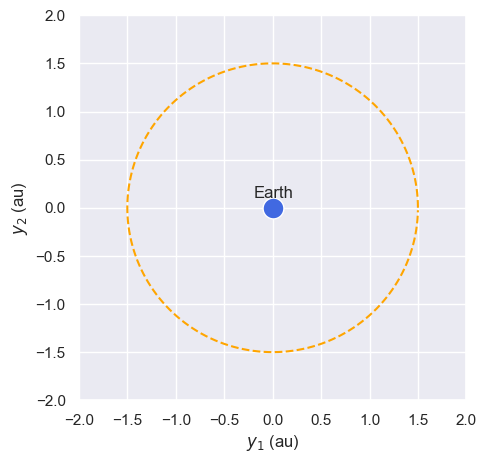

In [9]:
plt.figure(figsize=(5, 5))

plt.xlabel("$y_1$ (au)")
plt.ylabel("$y_2$ (au)")

plt.xlim(-2, 2)
plt.ylim(-2, 2)

# Plot Earth
plt.plot(0, 0, "o", markersize=15, markeredgecolor="white", markerfacecolor="royalblue")
plt.annotate("Earth", (0, 0), (-0.2, 0.1))

# Plot predicted orbit
plt.plot(x_pred, y_pred, "--", c="orange", label="Predicted orbit")
plt.savefig(fig_save_dir+"circular_orbit.pdf")

Of course, the radius and angular velocity are currently arbitrary choices.

We can try to fit them using a simple optimisation technique.

In the ancient days, astronomers will have to do this by hand, but now we can leverage computers!

Let us first write an objective function

```
objective([r, omega, t_0])
```

which outputs the mean-square difference of the predicted and true trajectories.

In [10]:
def objective(params: np.ndarray[float]) -> float:
    r, omega, t_0 = params
    x_pred, y_pred = circular_model(t_span, r=r, omega=omega, t_0=t_0)
    return np.sum((x_pred - relative_locations[:, 0])**2 + (y_pred - relative_locations[:, 1])**2)

We minimize the objective with respect to $r,\omega,t_0$ using the `minimize` routine from `scipy.optimize`. The default uses the `L-BFGS-B` method since we have a positivity constraint on $r$.

In [11]:
from scipy.optimize import minimize

In [12]:
from scipy.optimize import dual_annealing

In [13]:
results = dual_annealing(
    objective,
    bounds=[(0, 10), (-10, 10), (-10, 10)],
)
r_fitted, omega_fitted, t_0_fitted = results.x

Let us now visualise the fitted orbits

In [14]:
def plot_orbit(
    ax: plt.Axes,
    t_span: np.ndarray[float],
    observed_orbit: np.ndarray[float],
    predicted_orbit: np.ndarray[float],
) -> None:
    """Helper function to plot orbits
    """
    final_time = t_span[-1]
    # Plot the orbits
    ax.plot(
        observed_orbit[t_span, 0],
        observed_orbit[t_span, 1],
        "--",
        c="darkgray",
        label="Observed orbit",
    )
    ax.plot(
        predicted_orbit[t_span, 0],
        predicted_orbit[t_span, 1],
        "--",
        c="orange",
        label="Predicted orbit",
    )
    # Plot Mercury
    ax.plot(
        observed_orbit[final_time, 0],
        observed_orbit[final_time, 1],
        "o",
        markersize=10,
        markeredgecolor="white",
        markerfacecolor="dimgray",
    )
    ax.plot(
        predicted_orbit[final_time, 0],
        predicted_orbit[final_time, 1],
        "o",
        markersize=10,
        markeredgecolor="white",
        markerfacecolor="darkorange",
    )

We predict the trajectory with the fitted parameters.

In [15]:
x_pred, y_pred = circular_model(
    t=t_span, r=r_fitted, omega=omega_fitted, t_0=t_0_fitted
)

Observe below that the simple circular model is a poor model.

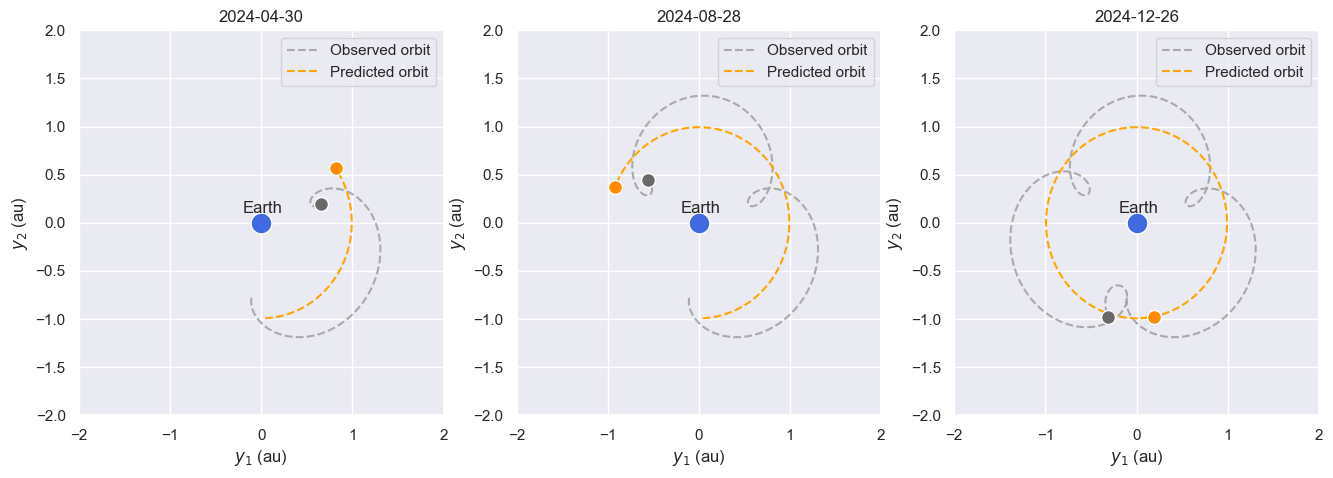

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

days = [120, 240, 360]

for d, ax in zip(days, axes):
    plot_orbit(ax, t_span[:d], relative_locations, np.column_stack([x_pred, y_pred]))
    ax.set_title(f"{dates[d]}")

for ax in axes:
    ax.set_xlabel("$y_1$ (au)")
    ax.set_ylabel("$y_2$ (au)")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax.plot(0, 0, "o", markersize=15, markeredgecolor="white", markerfacecolor="royalblue")
    ax.annotate("Earth", (0, 0), (-0.2, 0.1))
    ax.legend()

plt.savefig(fig_save_dir+"circular_orbit_fitted.pdf")

### The model of Ptolemy, Ibn al-Shatir and Copernicus

Now, we adopt the multiple circular model.
In this case, it is much easier to work in the complex plane.

In this case, we can simply write the orbit as
$$
    z(t) = \sum_{j=1}^{m} a_j \exp{i \omega_j t}
$$
where $a_j$ are complex numbers and $\omega_j$ are real numbers.

In [17]:
def multi_circular_model(
    t: np.ndarray[float], a: np.ndarray[complex], omega: np.ndarray[float]
) -> (np.ndarray[float], np.ndarray[float]):
    results = a[:, None] * np.exp(1j * omega[:, None] * t[None, :])  # use broadcasting
    results = np.sum(results, axis=0)
    return results.real, results.imag

Now let us fit a model with multiple circles.

We begin by defining the optimisation objective.

In [18]:
def objective(params: np.ndarray[float]) -> float:
    a_real, a_imaj, omega = np.split(params, 3)
    x_pred, y_pred = multi_circular_model(
        t=t_span, a=a_real + 1j * a_imaj, omega=omega
    )
    return np.sum(
        (x_pred - relative_locations[:, 0]) ** 2
        + (y_pred - relative_locations[:, 1]) ** 2
    )

We build a three-circles model and fit them from Mercury trajectory data.

In [19]:
num_circles = 3
bounds = [(-1, 1),]*(num_circles * 3)
results = dual_annealing(objective, bounds=bounds)
a_real_fitted, a_imaj_fitted, omega_fitted = np.split(results.x, 3)

Let us test the predictions.

In [20]:
x_pred, y_pred = multi_circular_model(
    t=t_span,
    a=a_real_fitted + 1j * a_imaj_fitted,
    omega=omega_fitted,
)

This model did pretty well!

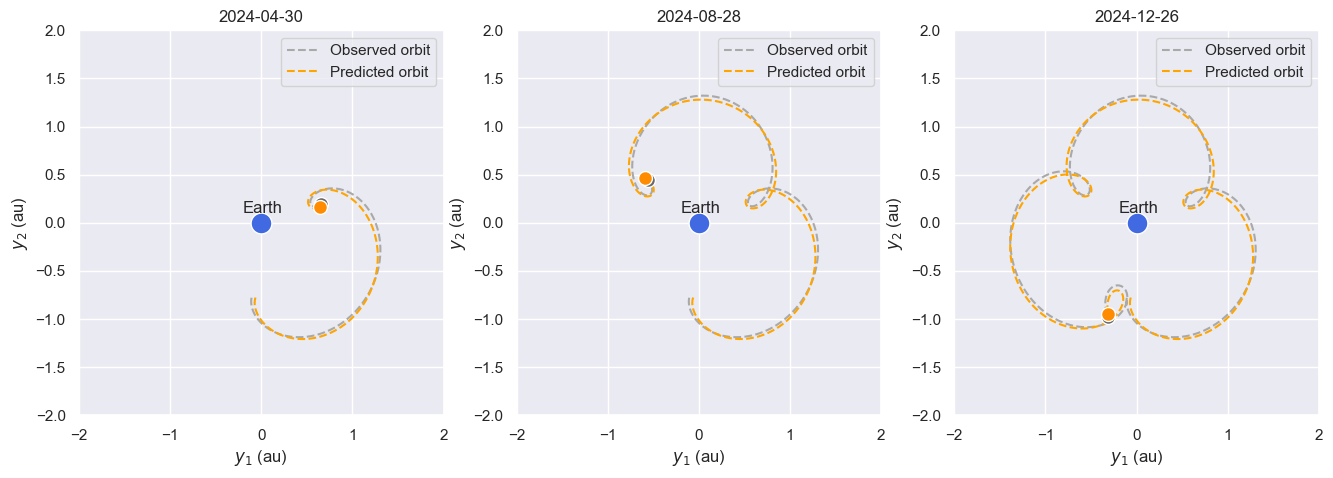

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

days = [120, 240, 360]

# Plot orbits
for d, ax in zip(days, axes):
    plot_orbit(ax, t_span[:d], relative_locations, np.column_stack([x_pred, y_pred]))
    ax.set_title(f"{dates[d]}")

# Annotations
for ax in axes:
    ax.set_xlabel("$y_1$ (au)")
    ax.set_ylabel("$y_2$ (au)")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax.plot(0, 0, "o", markersize=15, markeredgecolor="white", markerfacecolor="royalblue")
    ax.annotate("Earth", (0, 0), (-0.2, 0.1))
    ax.legend()

plt.savefig(fig_save_dir+"three_circles_model_fitted.pdf")

# Exercises

1. Can you make an even more accurate model using more circles?
2. Try some other modelling techniques besides circular revolution.